In [1]:
import simtools
from simtools import analysis_tools as at
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
import seaborn as sns

# STEP 1:
 ### Make the master hdf5 file from all the subordinate files

 ``` filenames = at.get_hdf5_files('hdf5_files', with_path=True)```
 <br>
 ``` master_file = at.merge_hdf5_files(filenames, 'master.h5') ```


In [64]:
# filenames = at.get_hdf5_files('data/big_h5/', with_path=True)
# master_file = at.merge_hdf5_files(filenames, '150_years')

In [65]:
h5_file = '150_years.hdf5'

# STEP 2
### Using plotting functions from the analysis tools module, plot various datasets in the hdf5 file

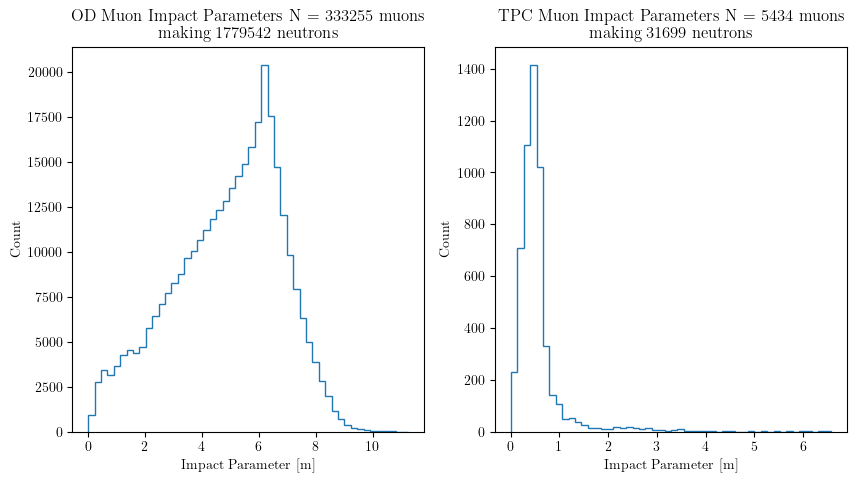

In [66]:
with h5.File(h5_file, 'r') as file:
   at.plot_both_impact_hist(file, bins=50)

29.83289241792327


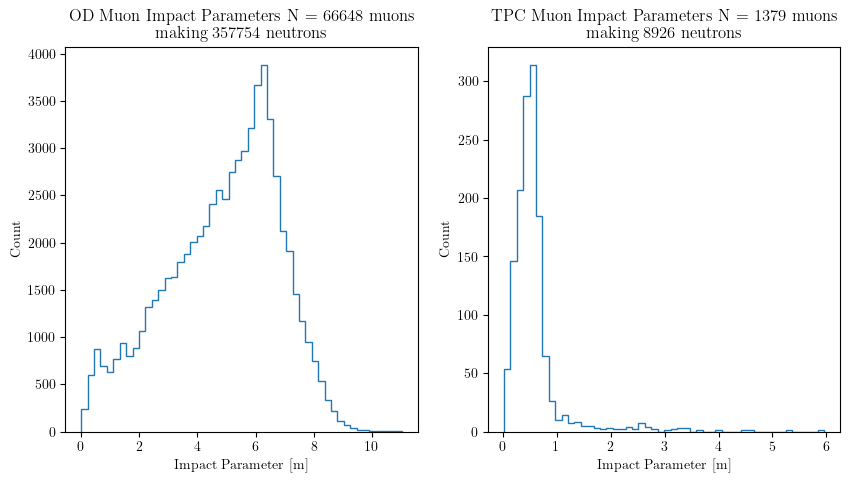

In [67]:
with h5.File('large_roi.h5', 'r') as file:
   at.plot_both_impact_hist(file, bins=50)
   print(at.get_total_years(file))

In [68]:
with h5.File(h5_file, 'r') as file:
    at.print_summary(file)

Summary of Fluka File:

Muons Simulated: 5187840
Intersecting ROI Radius: 8.1722[m] Height: 16.8 [m]
333255 muons creating 1779542 neutrons in the OD
5434 muons creating 31699 neutrons in the TPC
Xenon-137 atoms counted: 3287.9994924000002
Copper-64 atoms counted in TPC shell: 10045.0215534
Copper-66 atoms counted in TPC shell: 2181.9953715
Time Simulated: 1308805.776356392 hours or 149.40705209547855 years


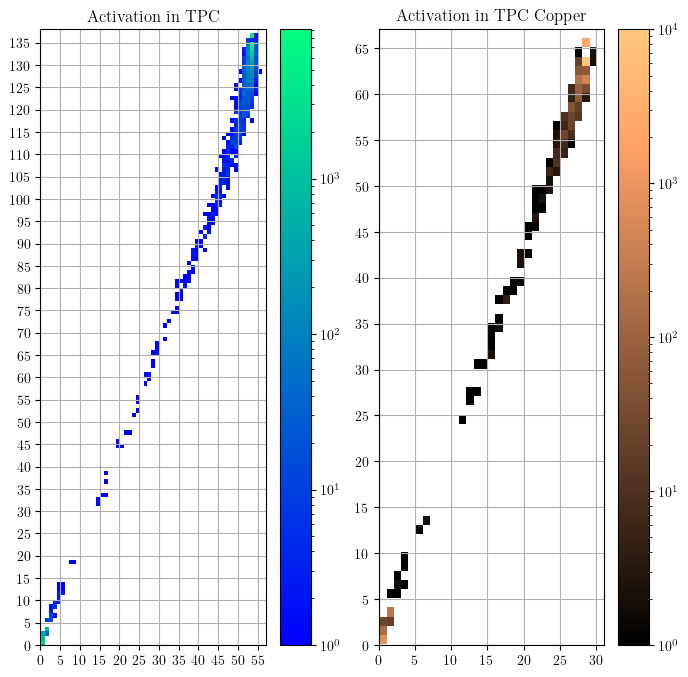

In [69]:
with h5.File(h5_file) as file:
    at.activation_plot(file)

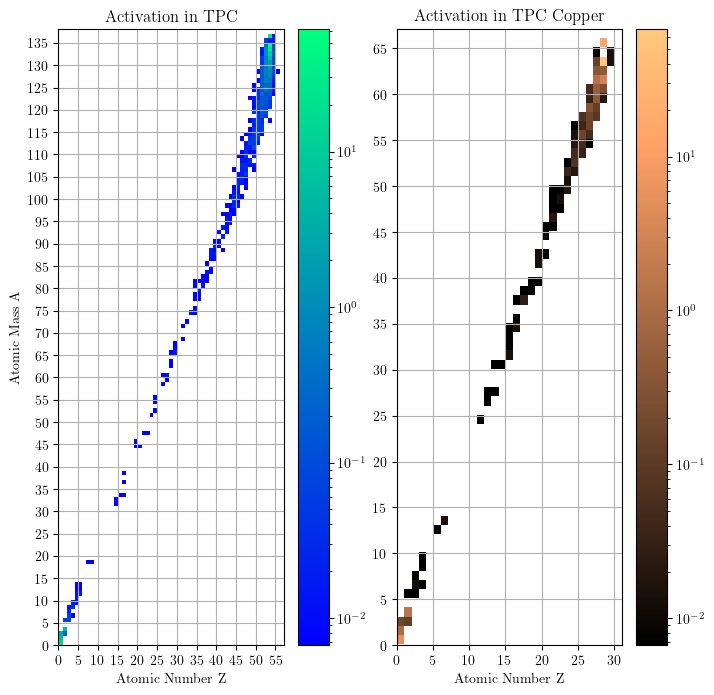

In [70]:
with h5.File(h5_file) as file:
    at.activation_plot_per_year(file)

In [9]:
np.sqrt((12.8/2)**2 + (6.1722)**2)

8.891347076793258

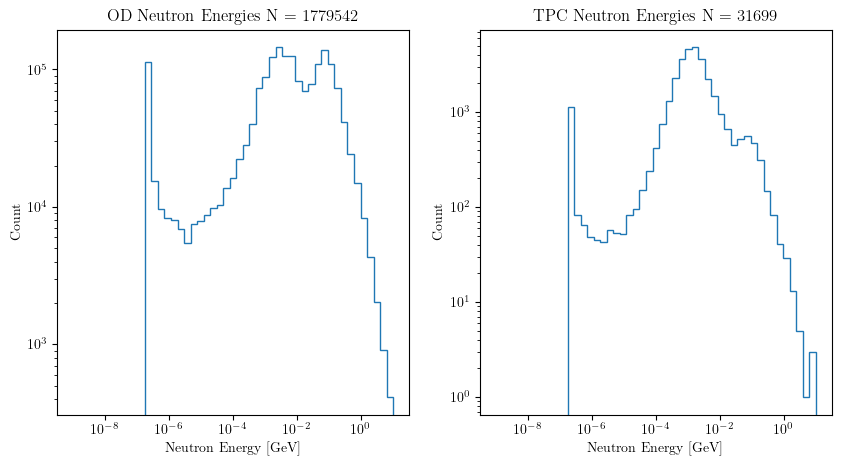

In [71]:
with h5.File(h5_file) as file:
    at.plot_both_energy_hist(file, bins = 50)

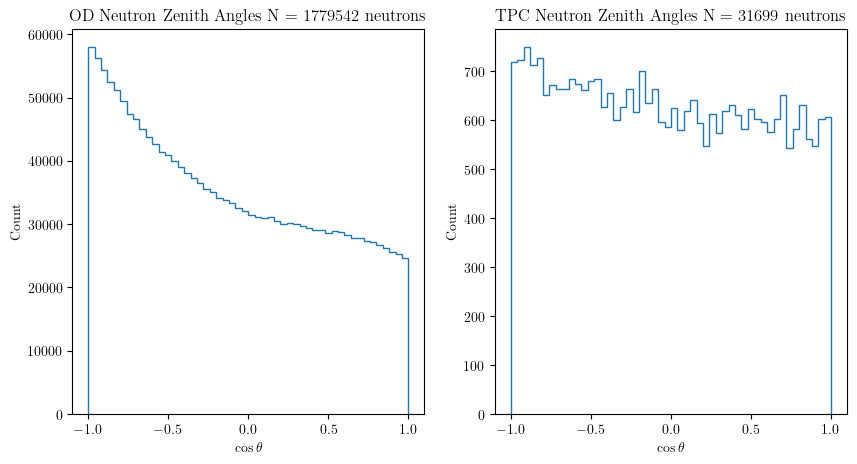

In [72]:
with h5.File(h5_file, 'r') as file:
    at.plot_coz_neutrons(file)

### Making an activation file:
Isotopes from within the TPC Region

In [12]:
with h5.File('new_isotopes.h5') as file:
    with open('activation.csv', 'w') as activation:
        resnuclei_array = at.tabulate_resnuclei_data(file['resnuclei']['resnuclei'])*file['meta']['muons_simulated'][0]/at.get_total_years(file)
        
        for z in range(np.shape(resnuclei_array)[0]):
            for a in range(np.shape(resnuclei_array)[1]):
                if resnuclei_array[z][a] > 0:
                    activation.write(str(z) + ', ' + str(a) + ', ' + str(resnuclei_array[z][a]) + '\n')


In [13]:
with h5.File('new_isotopes.h5') as file:
    print(at.get_total_years(file))

20.43363456892035


In [19]:
from simtools import muon_functions as mf

In [23]:
ROI = mf.OuterDetector(radius = mf.OD_RADIUS + 2, height= mf.OD_HEIGHT + 4)
intersecting = mf.intersecting_muons_with_time(int(1e6), ROI)

In [24]:
intersecting

(array([<simtools.muon_functions.Muon object at 0x1e16b6ad0>,
        <simtools.muon_functions.Muon object at 0x1e15f9ed0>, ...,
        <simtools.muon_functions.Muon object at 0x202816b60>], dtype=object),
 252080.18947285097)

In [27]:
252080.189/(24*365)

28.776277283105024

In [45]:
x = 5790
print(x*0.252080189/(24*365))

0.1666146454691781


# Producing the Violin Plot of Activated Isotopes

We'll need at least 1000 versions of 6 random files chosen from the `/data/big_h5' directory. Each file in that directory is 2 months worth of data

In [37]:
filenames = at.get_hdf5_files('data/big_h5', with_path=True)
number_of_files = len(filenames)
number_of_years = 10000

## How to randomly chooose sets of 6 files?

We can begin by making 1000 arrays of random numbers from 0 to 896 like this:

```np.random.randint(0, number_of_files, 6 )```

In [38]:
index_array = np.zeros((number_of_years,6), dtype=int)
for row in index_array:
    row[:] = np.random.randint(0, number_of_files, 6 )

In [48]:
xe_137_counts = np.zeros(number_of_years, dtype=int)
cu_64_counts = np.zeros(number_of_years, dtype=int)
cu_66_counts = np.zeros(number_of_years, dtype=int)

list_index = 0
for row in index_array:
    for index in row:
        xe_137_counts[list_index] += at.get_activation(filenames[index], 54, 137, True)
        cu_64_counts[list_index] += at.get_activation(filenames[index], 29, 64, False)
        cu_66_counts[list_index] += at.get_activation(filenames[index], 29, 66, False)
    list_index += 1

## Now we have the equivalent of 10000 years of counts in the array `xe_137_counts`

So we can make a histogram of this array


In [49]:
import pandas as pd

data_dict = {'Xe-137':  xe_137_counts,
             'Cu-64':   cu_64_counts,
             'Cu-66':   cu_66_counts}

act_df = pd.DataFrame(data_dict)
act_df['Cu-64']

0        15
1        67
2        10
3       126
4        76
       ... 
9995     13
9996     98
9997     20
9998     30
9999     27
Name: Cu-64, Length: 10000, dtype: int64

Text(0.5, 0, 'Activated Isotopes')

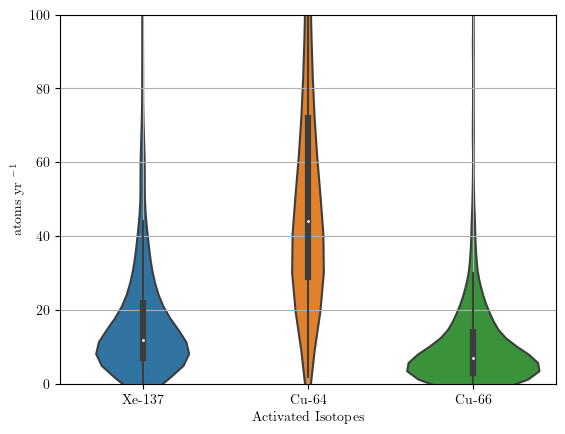

In [63]:
ax = sns.violinplot(act_df)
ax.set_ylim((0,100))
ax.grid()
ax.set_ylabel(r'atoms yr $^{-1}$')
ax.set_xlabel(r'Activated Isotopes')